In [1]:

import os  
import numpy as np  
import random  
from PIL import Image, ImageEnhance  
from tensorflow.keras.preprocessing.image import load_img  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.applications import VGG16 
from sklearn.utils import shuffle  

In [3]:
train_dir = "D:\disease\Training"
test_dir = "D:\disease\Testing"

In [4]:
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

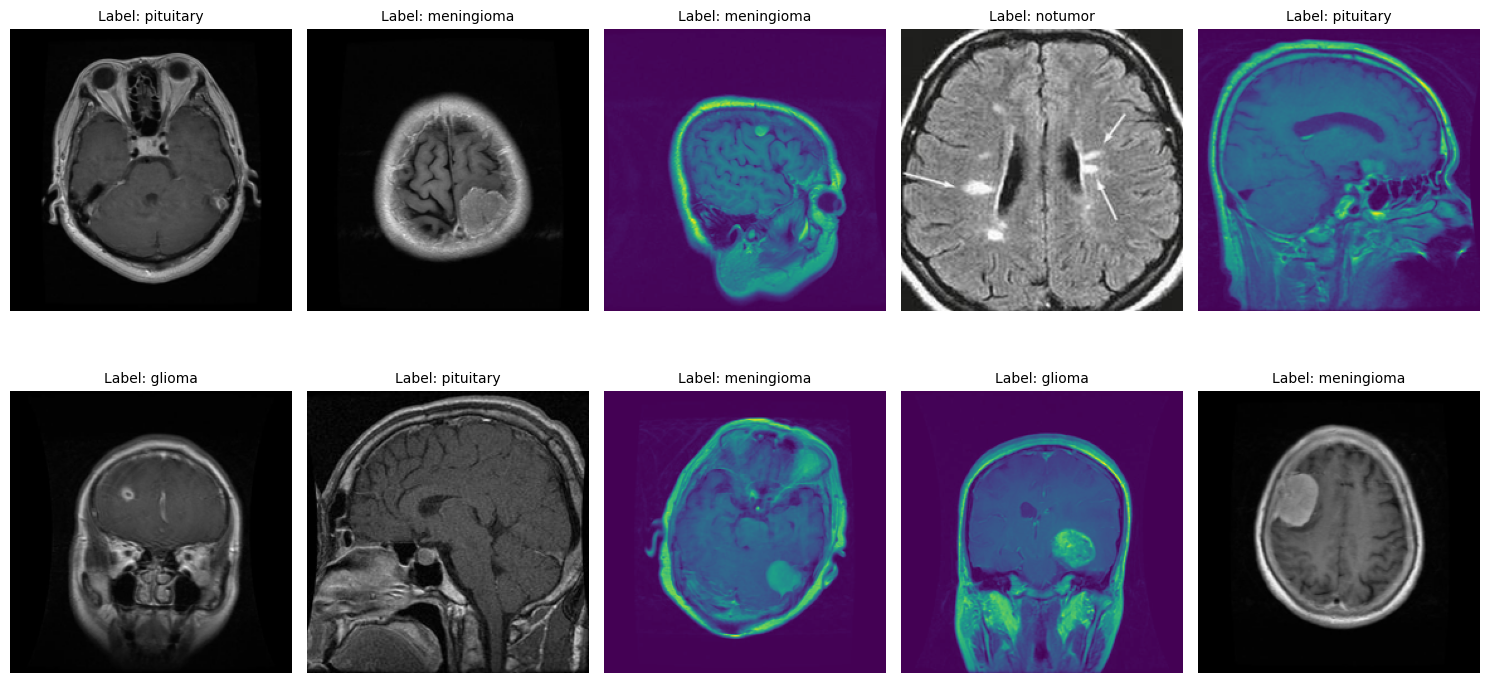

In [ ]:
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(train_paths)), 10)


fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224)) 

    axes[i].imshow(img)
    axes[i].axis('off')  
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2)) 
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2)) 
    image = np.array(image) / 255.0  
    return image

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

def encode_label(labels):
    unique_labels = os.listdir(train_dir) 
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths) 
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels) 
            yield batch_images, batch_labels 

In [8]:
IMAGE_SIZE = 128  
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  
model.add(base_model)  
model.add(Flatten())  
model.add(Dropout(0.3)) 
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.2))  
model.add(Dense(len(os.listdir(train_dir)), activation='softmax')) 


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


batch_size = 20
steps = int(len(train_paths) / batch_size)  
epochs = 5

history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - loss: 0.6425 - sparse_categorical_accuracy: 0.7384
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - loss: 0.2481 - sparse_categorical_accuracy: 0.9098
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 720s 3s/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9402
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 775s 3s/step - loss: 0.1147 - sparse_categorical_accuracy: 0.9553
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - loss: 0.0963 - sparse_categorical_accuracy: 0.9618


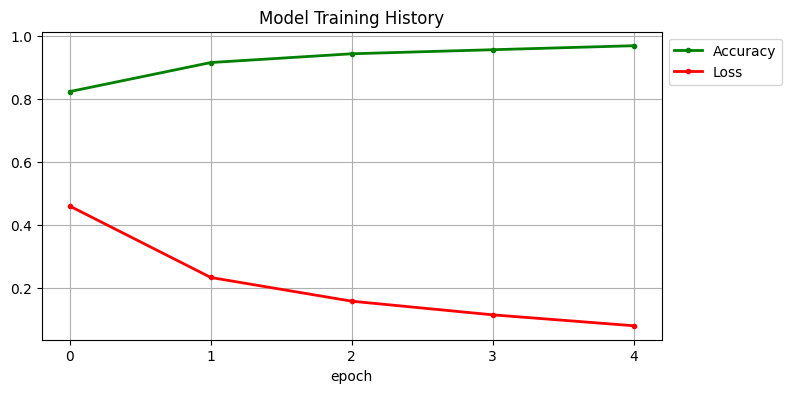

In [9]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)
test_predictions = model.predict(test_images)
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.90       300
           1       0.83      0.99      0.90       306
           2       0.99      1.00      0.99       405
           3       1.00      0.96      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.96      0.95      0.95      1311



Confusion Matrix:
[[248  52   0   0]
 [  0 302   4   0]
 [  0   0 405   0]
 [  1  11   1 287]]


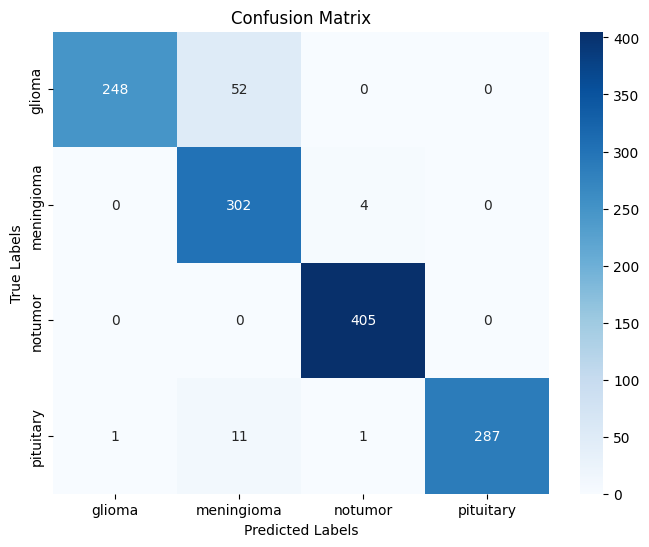

In [13]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

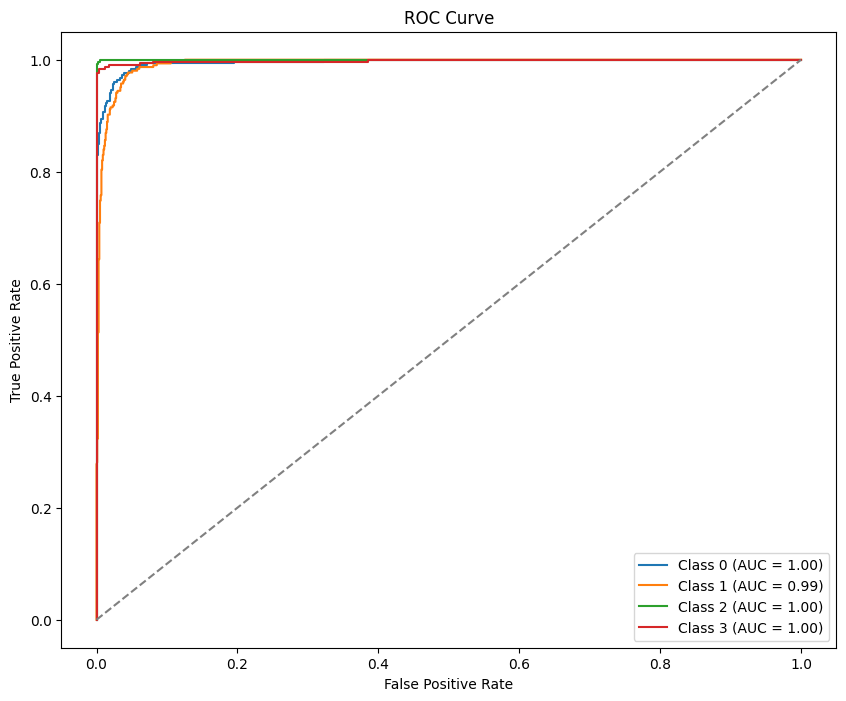

In [14]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [15]:
model.save('model.h5')

In [16]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [17]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']
def detect_and_display(img_path, model, image_size=128):
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0 
        img_array = np.expand_dims(img_array, axis=0)  
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


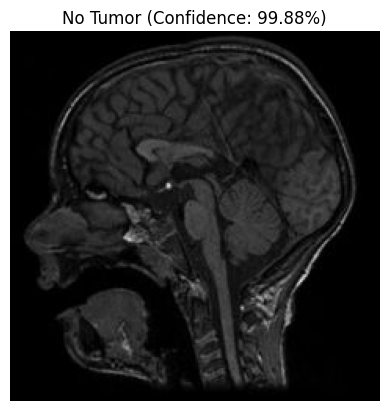

In [22]:
image_path = "D:/disease/Testing/notumor/Te-no_0038.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


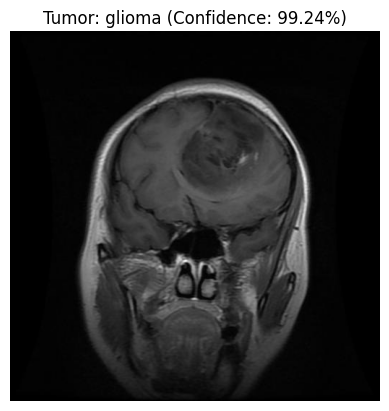

In [27]:
image_path = "D:\disease\Testing\glioma\Te-gl_0254.jpg"
detect_and_display(image_path, model)